----
# Data EDA
----

### Notebook Overview

In this notebook, I will explore the seasonal patterns and trends in the Microsoft stock data, focusing on the close price. 
The key areas of analysis include:

- **Exploring Overall Trend:** Analysing the long-term movement in the close price to identify the general direction of the stock over time. This includes examining data aggregated at daily, weekly and monthly levels.
- **Exploring Monthly Seasonality:** Seasonal plot of the stock data aggregated by month, allowing us to observe monthly patterns and trends. This plot helps ito understand how the stock behaves over different times of the year.
- **Seasonal-Trend Decomposition:** Breaking down the data into its seasonal, trend and residual components to better understand the data.
- **Stationarity Testing:** Assessing whether the data is stationary (its statistical properties do not change over time, i.e. constant mean and variance), which is required for accurate forecasting.
- **Seasonal Differencing and Box-Cox Transformation:** Applying techniques like seasonal differencing and the Box-Cox transformation to stabilise variance and improve stationarity.
- **Saving Stationary Data:** Exporting the transformed, stationary dataset for use in future forecasting and modelling.

This analysis will help uncover underlying patterns in the data, preparing it for forecasting and modelling.



## Set Up
----

In [65]:
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox

## Utility Functions
----

In [23]:
def plt_close(dataframe, aggregation):
    """
    Description:
    Plots the close prices of a given DataFrame, aggregated by the given period.

    Parameters:
    dataframe : The DataFrame containing stock data with a DateTime index.
    aggregation : The aggregation level for the plot (e.g., 'Daily', 'Weekly', 'Monthly').

    Returns:
    Displays a line plot of the close prices over the past 5 years.
    
    """

    plt.figure(figsize=(12, 6))
    plt.plot(dataframe.index, dataframe['Close'], label=f'{aggregation} Close', color = 'teal')
    plt.title(f'{aggregation} Close Prices', fontweight = 'bold')
    ax = plt.gca()
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    ax.spines[['top','right']].set_visible(False)

    plt.legend()
    plt.show()

In [51]:
def plt_ts_comp(dataframe):
    """
    Description:
    Plots the trend, seasonal and residual components of a time series decomposition.

    Paramaters:
    dataframe : A DataFrame containing the time series data with 'Trend', 'Seasonal' and 'Residual' columns.
                The DataFrame should have a DateTime index.

    Returns:
    Displays a subplot figure with three separate plots for the trend, seasonal and residual components.
    """

    cols = ["Trend", "Seasonal", "Residual"]
    
    fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

    for i, col in enumerate(cols):
        fig.add_trace(
            go.Scatter(x=dataframe.index, y=dataframe[col]),
            row=i+1,
            col=1
        )

    fig.update_layout(height=800, width=1200, showlegend=False)
    fig.show()

## Data Loading
----

In [24]:
msft_df = pd.read_csv('../../data/msft_cleaned.csv', index_col=0)

In [41]:
msft_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2019-09-12,131.667405,132.211832,130.731347,131.352203,2.701000e+07,0.0,0.0
2019-09-13,131.600570,131.868011,130.444847,131.161209,2.336310e+07,0.0,0.0
2019-09-14,130.979714,131.435000,130.155107,130.845998,2.115253e+07,0.0,0.0
2019-09-15,130.358857,131.001988,129.865367,130.530787,1.894197e+07,0.0,0.0
2019-09-16,129.738001,130.568977,129.575628,130.215576,1.673140e+07,0.0,0.0
...,...,...,...,...,...,...,...
2024-09-07,408.453328,409.983327,401.249990,403.040009,1.817137e+07,0.0,0.0
2024-09-08,407.846659,409.316661,401.699992,404.380005,1.673323e+07,0.0,0.0
2024-09-09,407.239990,408.649994,402.149994,405.720001,1.529510e+07,0.0,0.0
2024-09-10,408.200012,416.329987,407.700012,414.200012,1.959430e+07,0.0,0.0


## Checking datatypes
---

In [26]:
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1827 entries, 2019-09-12 to 2024-09-11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1827 non-null   float64
 1   High          1827 non-null   float64
 2   Low           1827 non-null   float64
 3   Close         1827 non-null   float64
 4   Volume        1827 non-null   float64
 5   Dividends     1827 non-null   float64
 6   Stock Splits  1827 non-null   float64
dtypes: float64(7)
memory usage: 114.2+ KB


### Reset Date to be datetime type

In [27]:
msft_df.index = pd.to_datetime(msft_df.index)

In [28]:
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2019-09-12 to 2024-09-11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1827 non-null   float64
 1   High          1827 non-null   float64
 2   Low           1827 non-null   float64
 3   Close         1827 non-null   float64
 4   Volume        1827 non-null   float64
 5   Dividends     1827 non-null   float64
 6   Stock Splits  1827 non-null   float64
dtypes: float64(7)
memory usage: 114.2 KB


In [29]:
msft_df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

## Exploring Overall Trend of Close Price
---

Using close price to assess trends since it reflects the final value of stock at the end of the trading day.

### Daily Plot

In [30]:
daily_msft_df = msft_df

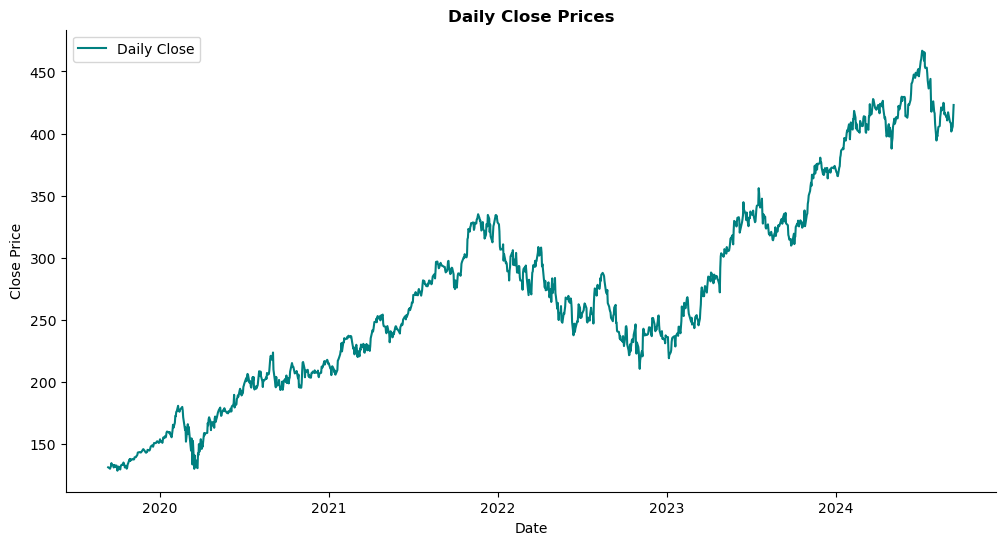

In [31]:
plt_close(daily_msft_df, 'Daily')

-----
**Plot Description:**

Overall, Microsoft's stock price shows a clear upward trend over the 5-year period, reflecting positive company growth.

A notable dip is observed between 2022 and 2023, which may be due to the economic impact of the Russia-Ukraine war. This event contributed to market instability and inflation, both of which played a role in the decline in tech stocks which fell by more than 30% in 2022 [1]. The increased volatility during this period also shows market's reaction to these disruptive factors.

From 2023, Microsoft’s stock shows signs of recovery, likely due to a stabilsation in market conditions leading to greater investor confidence. This upward trend could also be driven by the release of new products/updates.

[1] https://www.forbes.com/sites/qai/2023/01/19/why-were-tech-stocks-down-in-2022-and-how-long-will-the-slump-last/#:~:text=Key%20takeaways%3A,inflation%20and%20uncertain%20economic%20conditions.


### Weekly Plot

In [32]:
# Aggregate to weekly frequency
weekly_msft_df = msft_df[['Close']].resample('W').mean()

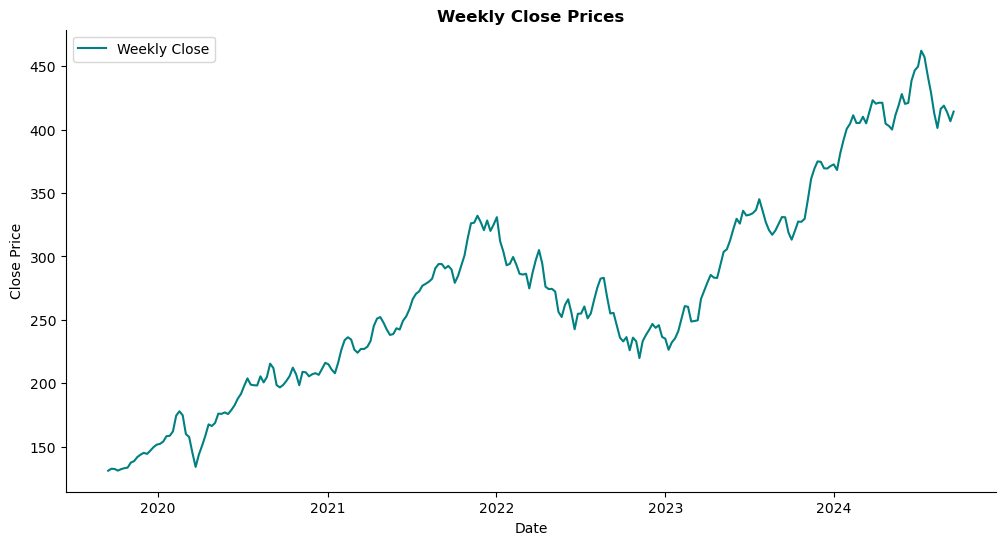

In [33]:
plt_close(weekly_msft_df, 'Weekly')

----
**Plot Description:**

The weekly plot of close prices closely follows the daily plot. Underlying trends and patterns identified are similar for both daily and weekly timeframes.

The weekly aggregation using resampling smooths out the fluctatuations we see in the daily plot. This makes the overall trends clearer and easier to follow.

### Monthly Plot

In [34]:
monthly_msft_df = msft_df[['Close']].resample('MS').mean()

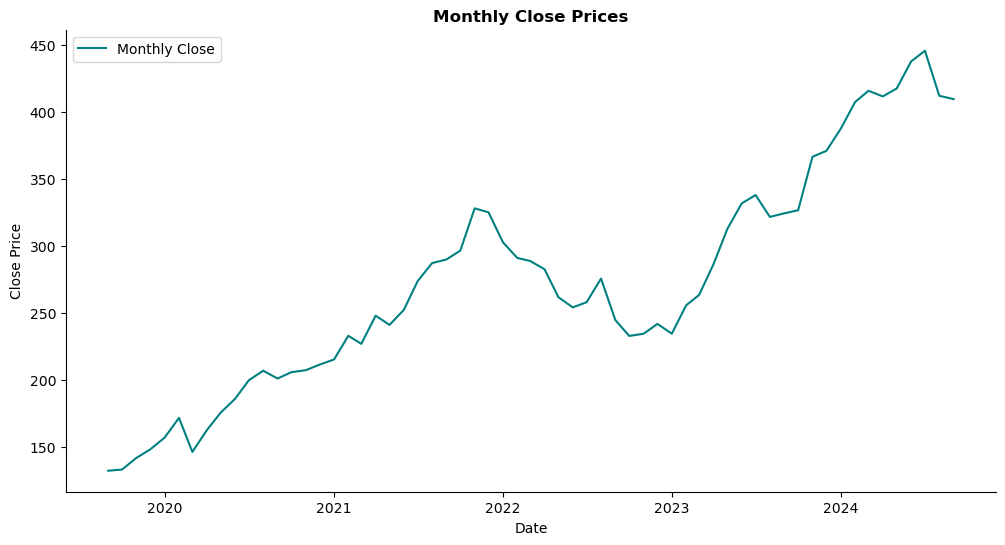

In [35]:
plt_close(monthly_msft_df, 'Monthly')

----
**Plot Description:**

The monthly plot of close prices provides a high-level view of the stock’s performance over time. 

This aggregation smooths out the fluctuations seen in the daily and weekly plots, highlighting longer-term trends and patterns more clearly and offers more of a straightforward understanding of the stock's overall performance.

## Seasonal Plot
----

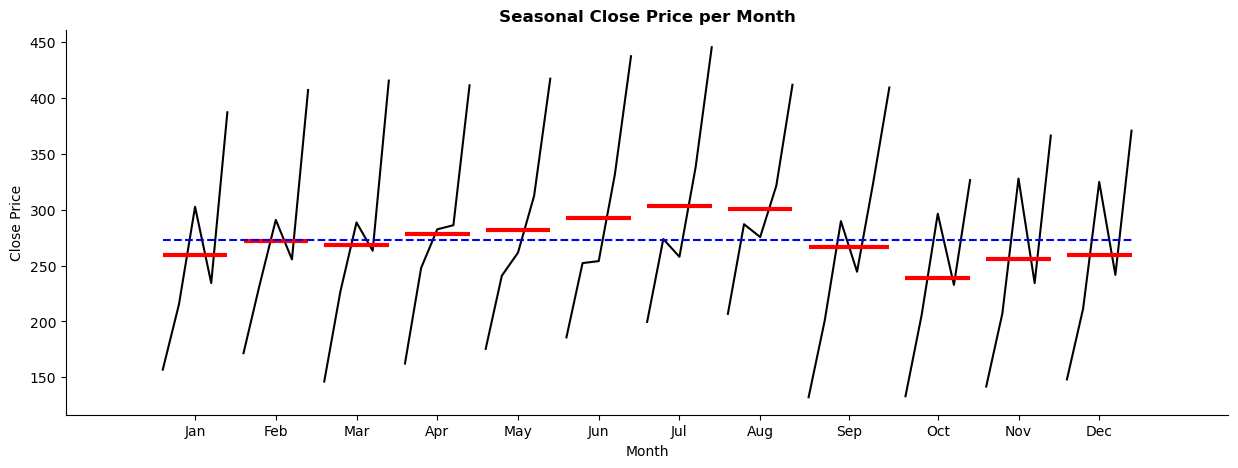

In [39]:
from statsmodels.graphics.tsaplots import month_plot

plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(monthly_msft_df["Close"], ax=plt.gca())

# adding a horizontal line for the mean
plt.hlines(y=monthly_msft_df.mean(),  xmin=0, xmax=60, color='blue', linestyles='--')

plt.title("Seasonal Close Price per Month", fontweight = 'bold')
plt.ylabel('Close Price')
plt.xlabel('Month')
sns.despine()
plt.show()

-----
**Plot Description:**

The plot above explores the seasonality of the stock close prices over the 5 year period. 

**Key insights:**

- April to August show higher than average close prices with a peak June
    - Steady increase from April to June in average close prices, this suggests stronger market performance for Microsoft in the spring to summer months.
    - To investigate if there any release or events where new products are unveiled, both could be reasons which drive the stock price up.

- September to December show lower than average close prices
    - Investors could be choosing to sell their stocks during this time after their gain
    - See if there is a simialar trend in tech stocks as a whole as this would influence Microsofts stock prices.

- Decemeber to February show recovery 
    - A slight upward trend from November to February
    - Could be due to Christmas, there is a tendency for stock prices to rise in the final week of Decemeber and the first few days of January.
    - Greater optimism at the start of the year as end of the year financial reports tend to include future steps which could attract investors/drive stocks up.

## Seasonal-Trend Decomposition
----

Seasonal trend decomposition breaks down the timeseries into three elements:

1. Trend 
    - Used to show long-term patterns in the data.
    - Usually used to indicate whether data is on the rise, decline or remains cosntant over time.
2. Seasonality
    - Used to capture short-term repeating cycles in the data such as weekly or monthly patterns.
3. Residuals
    - Captures noise in the data.
    - Usually represents anomalies that are not explained by trend or seasonality.


The objective of this project is to to forecast future Microsft stock prices and trends, I thought it best to not aggregate my data into weekly, monthly levels and continue with only looking at daily stock prices. Daily data offers granularity, since the stock martket is highly volatile using daily data would be able to capture more insights. Hopefully, this will lead to a more robust and accurate forecasts.

In [46]:
msft_decomp_df = msft_df.copy()

In [52]:
# decompose the time series using seasonal_decompose function
# data appears additive, as the variations in the overall trend plot seem random and do not increase in magnitude with the trend
decomposition = tsa.seasonal_decompose(msft_decomp_df['Close'], model='additive')

In [53]:
# add the decomposition data
msft_decomp_df["Trend"] = decomposition.trend
msft_decomp_df["Seasonal"] = decomposition.seasonal
msft_decomp_df["Residual"] = decomposition.resid

msft_decomp_df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Trend,Seasonal,Residual
2019-09-12,131.667405,132.211832,130.731347,131.352203,2.701000e+07,0.0,0.0,NaN,0.089411,NaN
2019-09-13,131.600570,131.868011,130.444847,131.161209,2.336310e+07,0.0,0.0,NaN,0.217409,NaN
2019-09-14,130.979714,131.435000,130.155107,130.845998,2.115253e+07,0.0,0.0,NaN,0.081202,NaN
2019-09-15,130.358857,131.001988,129.865367,130.530787,1.894197e+07,0.0,0.0,131.091594,-0.061176,-0.499631
2019-09-16,129.738001,130.568977,129.575628,130.215576,1.673140e+07,0.0,0.0,131.575989,-0.184360,-1.176052
2019-09-17,130.817320,131.352201,130.311077,131.228027,1.781420e+07,0.0,0.0,131.865258,-0.276130,-0.361101
2019-09-18,131.199380,132.450624,130.406604,132.307358,2.398210e+07,0.0,0.0,132.185912,0.133646,-0.012199
2019-09-19,134.007496,135.984649,133.787816,134.742966,3.577210e+07,0.0,0.0,132.537949,0.089411,2.115606
2019-09-20,134.685674,135.296969,132.049466,133.186096,3.916730e+07,0.0,0.0,132.921369,0.217409,0.047318
2019-09-21,134.118943,134.653829,132.109950,133.090571,3.182463e+07,0.0,0.0,132.920013,0.081202,0.089356


In [54]:
# Plotting the trend, seasonal and residual components
plt_ts_comp(msft_decomp_df)

-----
**Plot Description:**

Hard to seasonality over the 5 years for daily data, will reduce the date range to the previous year and a half to inspect the seasonality. This will also ensure focus on the most recent trends in the stock market.

In [59]:
msft_decomp_df.index.max()

Timestamp('2024-09-11 00:00:00')

In [60]:
msft_decomp_r_df = msft_decomp_df.loc[(msft_decomp_df.index >= '2023-09-11'), ['Close']]


In [61]:
msft_decomp_r_df

,Close
2023-09-11,335.422333
2023-09-12,329.298248
2023-09-13,333.556305
2023-09-14,336.176636
2023-09-15,327.759827
...,...
2024-09-07,403.040009
2024-09-08,404.380005
2024-09-09,405.720001
2024-09-10,414.200012


In [62]:
# decompose the time series
decomposition = tsa.seasonal_decompose(msft_decomp_r_df['Close'], model='additive')

In [63]:
msft_decomp_r_df["Trend"] = decomposition.trend
msft_decomp_r_df["Seasonal"] = decomposition.seasonal
msft_decomp_r_df["Residual"] = decomposition.resid

msft_decomp_r_df.head(10)

,Close,Trend,Seasonal,Residual
2023-09-11,335.422333,NaN,-0.033544,NaN
2023-09-12,329.298248,NaN,-0.227124,NaN
2023-09-13,333.556305,NaN,0.225678,NaN
2023-09-14,336.176636,330.940234,-0.152277,5.388679
2023-09-15,327.759827,329.681109,0.155380,-2.076662
2023-09-16,327.376038,329.238717,0.066618,-1.929298
2023-09-17,326.992249,327.070701,-0.034732,-0.043720
2023-09-18,326.608459,324.352530,-0.033544,2.289473
2023-09-19,326.201508,322.479449,-0.227124,3.949183
2023-09-20,318.380188,320.686243,0.225678,-2.531733


In [64]:
plt_ts_comp(msft_decomp_r_df)

----
**Plot Description:**

**Trend Plot**

Throughout the year, there is a clear upward trend in stock prices for Microsoft suggesting solid company growth. 

**Seasonal Plot**

Now able to see the seasanlity of data, data seems to follow a weekly cycle. Data appears to peak every Wednesday and dip each Tuesday.

**Residual Plot**

The residual plot should show randomness with no obvious patterns. This indicates that the seasonality and trend components have effectively captured patterns in the data, leaving the residuals as random noise. 

Although the variance in the residuals is not constant and shows some fluctuations, there are no clear patterns. This suggests that the model has performed reasonably well but may still be missing some patterns in the data.

## Stationarity
----

Many forecasting methods require data to be stationary, this means the mean and varaince of the data do not change overtime. This is as some advnaced forecasting methods require all data points to follow the same distribution to be effective. To do this, I will do the following:

1. **BoxCox Transformation:** A method used to normalise both mean and variance of data. It can be applied using the boxcox function from scipy.stats. 


2. **Differencing:** A method which removes the trend in data by subtracting previous value from the current value. If the data shows seaonality, it subtracts value from the same season in a previous cycle, this removes seasonal patterns in the data.



### BoxCox Transformation

In [71]:
# Apply boxcox first to stabalise the mean and variance
msft_decomp_df['Close_boxcox'], lam = boxcox(msft_decomp_df['Close'])

### Seasonal Differencing

Seasonal differencing is used in cases where seasonal effects are seen in the dataset. For this project, this is observed in the residual plot for the daily stock prices. This method removes/reduces seasonality by subtracting the value of the time series at a previous seasonal period from the current value.

In [73]:
# Already know seasonality of Close is 7 days
msft_decomp_df['Close_diff'] = msft_decomp_df['Close_boxcox'].diff(7)

In [74]:
msft_decomp_df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Trend           6
Seasonal        0
Residual        6
Close_boxcox    0
Close_diff      7
dtype: int64

In [75]:
# Dropping na introduced
msft_decomp_df = msft_decomp_df.dropna()

In [77]:
msft_decomp_df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Trend,Seasonal,Residual,Close_boxcox,Close_diff
2019-09-19,134.007496,135.984649,133.787816,134.742966,3.577210e+07,0.0,0.0,132.537949,0.089411,2.115606,15.339153,0.181468
2019-09-20,134.685674,135.296969,132.049466,133.186096,3.916730e+07,0.0,0.0,132.921369,0.217409,0.047318,15.256175,0.108795
2019-09-21,134.118943,134.653829,132.109950,133.090571,3.182463e+07,0.0,0.0,132.920013,0.081202,0.089356,15.251065,0.120711
2019-09-22,133.552212,134.010689,132.170435,132.995046,2.448197e+07,0.0,0.0,133.034633,-0.061176,0.021589,15.245953,0.132649
2019-09-23,132.985481,133.367549,132.230919,132.899521,1.713930e+07,0.0,0.0,132.825862,-0.184360,0.258019,15.240839,0.144610
2019-09-24,134.064880,134.380081,130.740961,131.218536,2.977320e+07,0.0,0.0,132.592534,-0.276130,-1.097867,15.150474,-0.000512
2019-09-25,131.333116,133.682791,129.929044,133.109695,2.138200e+07,0.0,0.0,132.431981,0.133646,0.544068,15.252089,0.043004
2019-09-26,133.186064,133.892866,132.230915,133.281570,1.745660e+07,0.0,0.0,132.344206,0.089411,0.847954,15.261281,-0.077872
2019-09-27,133.864256,134.064844,130.521232,131.552795,2.247770e+07,0.0,0.0,132.329206,0.217409,-0.993820,15.168498,-0.087677
2019-09-28,133.195665,133.701898,130.881017,131.966705,2.074543e+07,0.0,0.0,132.286898,0.081202,-0.401394,15.190779,-0.060287


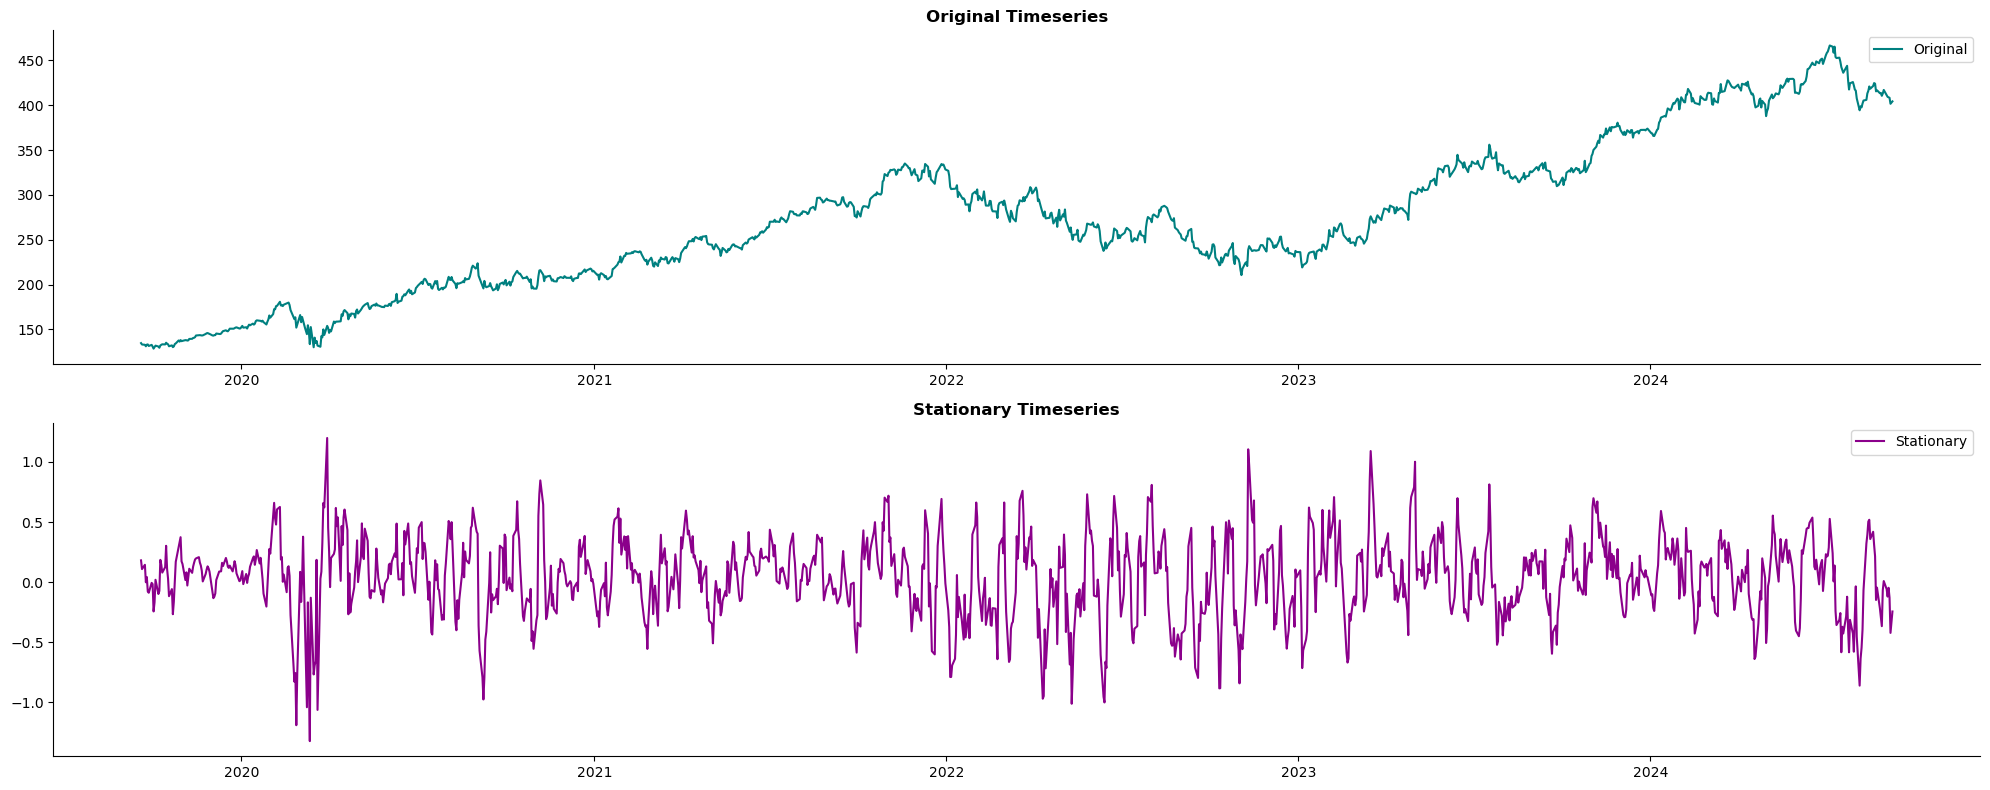

In [91]:
plt.figure(figsize=(20, 8))


plt.subplot(2, 1, 1)
plt.plot(msft_decomp_df['Close'], label='Original', color= 'teal')
plt.title('Original Timeseries', fontweight = 'bold')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(msft_decomp_df['Close_diff'], label='Stationary', color='darkmagenta')
plt.title('Stationary Timeseries', fontweight = 'bold')
plt.legend()

sns.despine()
plt.tight_layout()
plt.show()

----
**Plot Description:**

This plot compares the original timeseries with the stationary time series.

The original timeseries shows trends and seasonality in the data. In contrast, the stationary timeseries has been transformed to remove these trends and seasonality, resulting in a more stable mean and variance.

By comparing the two, you can observe how the transformation done above has standardised the data, making it more suitable for forecasting.


### Hypothesis Testing using ADF

ADF stands for Augmented Dickey-Fuller. It is a statistical test to determine if a given timeseries data is stationary. 

Test Hypotheses:

**Null Hypothesis H0:** Timeseries data is NOT stationary

**Alternate Hypothesis H1:** Timeseries data is stationary

In [92]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(msft_decomp_df['Close_diff'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -8.247423360312773
p-value: 5.50590353690287e-13


**Comment:** 

p-value is much less than 0.05 and so the null hypothesis is rejected. This means there is strong evidence to suggest that the data is now stationary after performing boxcox and seasonal differencing.

Now the timeseries data is ready for forecasting.


## Saving Stationary Daily Stock Data
---

In [93]:
msft_decomp_df.to_csv('../../data/msft_stat.csv')

## Conclusion
----

In this notebook, I explored the Microsoft stock data by decomposing it into its three main components: trend, seasonality and residuals. I identified a seasonal pattern with a periodicity of seven days and applied techniques such as differencing and Box-Cox transformation to achieve stationarity.

By performing these transformations and testing for stationarity, the data has been prepared for forecasting.